In [1]:
import numpy as np
import os, time, sys
import simnibs
from simnibs import sim_struct, run_simnibs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy
# import pymeshlab
import meshio
import stl
from stl import mesh

def find_elements_composed_by_given_nodes(mesh, node_number):
    # mesh: origin .msh
    # node_number: roi node number (>0)
    node_coord = mesh.nodes.node_coord
    node_number_set = set(node_number)
    elm_node_number_list = mesh.elm.node_number_list[:, :3]
    elm_node_number_index = np.array([i for i in range(mesh.elm.nr) if len(node_number_set & set(elm_node_number_list[i])) == 3])
    crop_elm_number = mesh.elm.elm_number[elm_node_number_index]
    return crop_elm_number

In [2]:
mesh_path = r'H:\3Headmodel\snowp\m2m_ernie\ernie.msh'
mesh      = simnibs.read_msh(mesh_path)
print('Vertices number of ernie head model mesh is: ', mesh.nodes.nr)
print('Tetrahedral elements number of ernie head model mesh is: ', np.sum(mesh.elm.elm_type == 4))

Vertices number of ernie head model mesh is:  834264
Tetrahedral elements number of ernie head model mesh is:  4690645


# 1. Discretize the L5 ROI surface mesh into the target number of meshes: 1000 elements

In [3]:
m2m_folder     = r'H:\3Headmodel\snowp\m2m_ernie'
sim_folder     = r'H:\3Headmodel\snowp\tacs_2mA'
meshlab_folder = os.path.join(sim_folder, 'meshlab_file')

L5_surf     = simnibs.read_msh(os.path.join(sim_folder, 'subject_overlays', 'ernie_TDCS_1_scalar_Layer5.msh'))
atlas       = simnibs.subject_atlas('a2009s', r'H:\3Headmodel\snowp\m2m_ernie')
region_name = ['lh.G_postcentral', 'lh.S_central', 'lh.G_precentral']
roi         = atlas[region_name[0]] + atlas[region_name[1]] + atlas[region_name[2]]
roi_bool    = roi.astype(bool)
roi_elm_number = find_elements_composed_by_given_nodes(L5_surf, L5_surf.nodes.node_number[roi_bool])
L5_surf_roi    = L5_surf.crop_mesh(elements=roi_elm_number)
print('Nodes number of L5 SOI mesh is: ', L5_surf_roi.nodes.nr)
print('Elements number of L5 SOI mesh is: ', L5_surf_roi.elm.nr)

Nodes number of L5 SOI mesh is:  8336
Elements number of L5 SOI mesh is:  16196


In [9]:
'''(1) Save the L5 ROI surface mesh in the .msh format'''
filename = 'Layer5_roi'
if not os.path.exists(os.path.join(meshlab_folder, '%s.msh' % filename)):
    simnibs.write_msh(L5_surf_roi, os.path.join(meshlab_folder, '%s.msh' % filename))
'''(2) Load the .msh file using meshio and save it as .obj surface file'''
if not os.path.exists(os.path.join(meshlab_folder, '%s.obj' % filename)):
    mesh_roi = meshio.read(os.path.join(meshlab_folder, '%s.msh' % filename))
    meshio.write(os.path.join(meshlab_folder, '%s.obj' % filename), mesh_roi)
'''(3) Load the .obj surface file using pymeshlab and perform mesh discretization'''
if not os.path.exists(os.path.join(meshlab_folder, '%s_pymeshlab.stl' % filename)):
    meshset = pymeshlab.MeshSet()
    meshset.load_new_mesh(os.path.join(meshlab_folder, '%s.obj' % filename))
    # 1. Re-discretize the ROI surface mesh to the number of target elements: such as 3000 triangular elements
    target_faces = 1000
    meshset.apply_filter('meshing_decimation_quadric_edge_collapse', targetfacenum=target_faces, qualitythr=0.5, preservetopology=True, optimalplacement=True)
    mesh = meshset.current_mesh()
    print(mesh.vertex_number(), mesh.face_number())
    # 2. Remove self-intersecting faces
    meshset.apply_filter('meshing_remove_duplicate_faces')
    # 3. Fill holes in the mesh
    meshset.apply_filter('meshing_close_holes', maxholesize=10)
    # 4. Remove non-manifold edges
    meshset.apply_filter('meshing_repair_non_manifold_edges', method='Remove Faces')
    # 5. Re-calculate the normal vectors of the triangle elements
    meshset.apply_filter('compute_normal_per_face')
    # 6. Save the final cortical surface mesh information in the .stl format, so that Simnibs can load it.
    meshset.save_current_mesh(os.path.join(meshlab_folder, '%s_pymeshlab.stl' % filename))


555 1000


# 2. Comparison chart before and after L5 SOI mesh discretization

In [4]:
sim_folder     = r'H:\3Headmodel\snowp\tacs_2mA'
meshlab_folder = os.path.join(sim_folder, 'meshlab_file')
filename       = 'Layer5_roi'
mesh_pre       = simnibs.read_msh(os.path.join(meshlab_folder, '%s.msh' % filename))
mesh_post      = simnibs.read_stl(os.path.join(meshlab_folder, '%s_pymeshlab.stl' % filename))

Text(0.5, 0.92, 'Before dicretization')

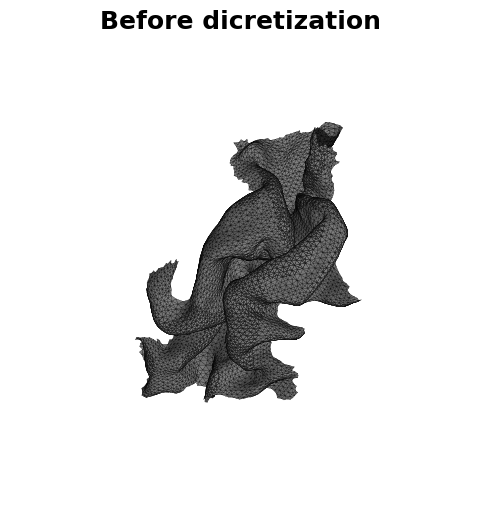

In [8]:
vertices = mesh_pre.nodes.node_coord
faces = mesh_pre.elm.node_number_list[:, :3] - 1
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices[face] for face in faces], facecolors=['gray'], edgecolors=['k'], shade=True, lw=0.2)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(60, 180)
ax.axis('equal')
ax.axis('off')
ax.set_title('Before dicretization', fontsize=18, fontweight='bold')

Text(0.5, 0.92, 'After dicretization')

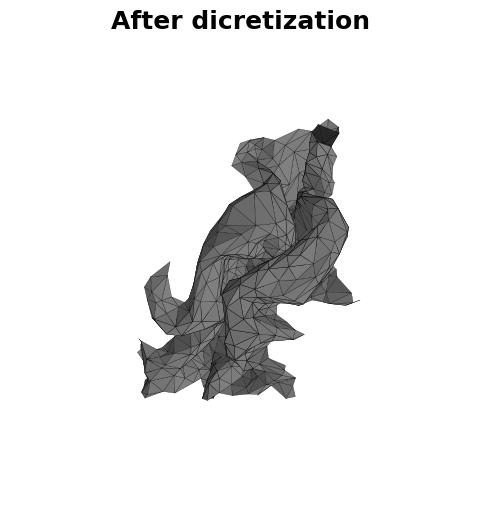

In [9]:
vertices = mesh_post.nodes.node_coord
faces = mesh_post.elm.node_number_list[:, :3] - 1
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices[face] for face in faces], facecolors=['gray'], edgecolors=['k'], shade=True, lw=0.2)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(60, 180)
ax.axis('equal')
ax.axis('off')
ax.set_title('After dicretization', fontsize=18, fontweight='bold')

# 3. Save the mesh information of the discretized L5 SOI surface (1000 elements): center coordinate, normal vector, etc.

In [2]:
sim_folder     = r'H:\3Headmodel\snowp\tacs_2mA'
meshlab_folder = os.path.join(sim_folder, 'meshlab_file')
filename       = 'Layer5_roi'
mesh_sim       = simnibs.read_stl(os.path.join(meshlab_folder, '%s_pymeshlab.stl' % filename))
# Extract the data and save it
faces        = mesh_sim.elm.node_number_list[:, :3]     
vertices     = mesh_sim.nodes.node_coord                
surface      = {'faces': faces, 'vertices': vertices}   
vnormals     = mesh_sim.nodes_normals().value           
cell_normals = mesh_sim.triangle_normals().value        
cell_origins = mesh_sim.elements_baricenters().value  
depth        = 0.75  # L5 normalized depth
num_elem     = mesh_sim.elm.nr                          
data = {'surface': surface,    'vnormals': vnormals, 'cell_normals': cell_normals, \
        'cell_origins': cell_origins, 'depth': depth, 'num_elem': num_elem}

# .npy format
savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_information_after_downsampling.npy'
if not os.path.exists(savePath):
    np.save(savePath, data)

# .mat format
savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_information_after_downsampling.mat'
if not os.path.exists(savePath):
    scipy.io.savemat(savePath, data)

# 4. Save the indices of the elements corresponding to the central frontal gyrus, central sulcus, and central posterior gyrus in the post-decisional downsampling grid.

In [20]:
m2m_folder     = r'H:\3Headmodel\snowp\m2m_ernie'
surf_folder    = os.path.join(m2m_folder, 'surfaces')
atlas          = simnibs.subject_atlas('a2009s', m2m_folder)

mesh_roi = simnibs.read_msh(r'H:\3Headmodel\snowp\tacs_2mA\meshlab_file\Layer5_roi.msh')
mesh_org = simnibs.read_gifti_surface(os.path.join(surf_folder, 'lh' + '.Layer5.gii'))                           # origin full L5 surface mesh, .msh file
mesh_org = mesh_org.join_mesh(simnibs.read_gifti_surface(os.path.join(surf_folder, 'rh' + '.Layer5.gii')))
# Determine the type of the area where each node is located
_, idx       = mesh_org.nodes.find_closest_node(mesh_roi.nodes.node_coord, return_index=True)
region_type  = np.zeros(mesh_org.nodes.nr)
region_type[atlas['lh.G_precentral']]  = 1
region_type[atlas['lh.S_central']]     = 2
region_type[atlas['lh.G_postcentral']] = 3
region_vinds = region_type[idx - 1]                   

# Determine the type of each element's location area
elm_node_number = mesh_roi.elm.node_number_list[:, :3]
elm_node_region_type = region_vinds[elm_node_number-1]
region_finds  = scipy.stats.mode(elm_node_region_type, axis=1, keepdims=False)[0] # The type of area where the ROI (Region of Interest) face is located, obtained by using scipy.stats.mode to find the mode (most frequent value)

precentral_indices  = np.where(region_finds == 1.0)[0]
central_indices     = np.where(region_finds == 2.0)[0]
postcentral_indices = np.where(region_finds == 3.0)[0]

if not os.path.exists('../data/pre_central_post_indices_original.npy'):
    data = {
        'precentral_indices': precentral_indices,
        'central_indices': central_indices,
        'postcentral_indices': postcentral_indices
    }
    np.save('../data/pre_central_post_indices_original.npy', data)
    # load data example
    # data = np.load('../data/pre_central_post_indices_original.npy', allow_pickle=True).item()

dataPath = '../data_matlab/pre_central_post_indices_original.mat'
if not os.path.exists(dataPath):
    data = {
        'precentral_indices': precentral_indices + 1,
        'central_indices': central_indices + 1,
        'postcentral_indices': postcentral_indices + 1
    }
    scipy.io.savemat(dataPath, data)

In [170]:
elm_node_region_type_sum = np.sum(elm_node_region_type, axis=1) # np.unique(elm_node_region_type_sum) = array([3., 4., 5., 6., 7., 8., 9.])
logic_indices_border1 = np.logical_and(elm_node_region_type_sum > 3.0, elm_node_region_type_sum < 6.0)
logic_indices_border2 = np.logical_and(elm_node_region_type_sum > 6.0, elm_node_region_type_sum < 9.0)
coords_border1 = mesh_roi.elements_baricenters()[logic_indices_border1, :]
coords_border2 = mesh_roi.elements_baricenters()[logic_indices_border2, :]
    
# Use the greedy algorithm to connect the points in sequence
# boader 1
from scipy.spatial.distance import cdist
points = coords_border1
start_point = np.array([-10.4612, -8.1752, 70.955])
start_point_index = np.argmin(np.linalg.norm(points - start_point, axis=1))
distance_matrix = cdist(points, points)
connected_order = [start_point_index] 
for _ in range(1, len(points)):
    last_point = connected_order[-1]
    nearest_point = np.argmin([distance_matrix[last_point][i] if i not in connected_order else np.inf for i in range(len(points))])
    # print(distance_matrix[last_point][nearest_point])
    if distance_matrix[last_point][nearest_point] < 5:
        connected_order.append(nearest_point)
coords_border1 = points[connected_order]

# boader 2
points = coords_border2
start_point = np.array([-11.6887, -13.2879, 71.8888])
start_point_index = np.argmin(np.linalg.norm(points - start_point, axis=1))
distance_matrix = cdist(points, points)
connected_order = [start_point_index] 
for _ in range(1, len(points)):
    last_point = connected_order[-1]
    nearest_point = np.argmin([distance_matrix[last_point][i] if i not in connected_order else np.inf for i in range(len(points))])
    # print(distance_matrix[last_point][nearest_point])
    if distance_matrix[last_point][nearest_point] < 5:
        connected_order.append(nearest_point)
coords_border2 = points[connected_order]

'''save data'''
dataPath = '../data_matlab/pre_central_post_border_coordinates.mat'
if not os.path.exists(dataPath):
    data = {
        'border_pre_central': coords_border1,
        'border_post_central': coords_border2
    }
    scipy.io.savemat(dataPath, data)

(-60.9085968931516,
 -7.03275658686956,
 -24.022069195906322,
 29.85377111037572,
 32.347844039400414,
 72.75472426911195)

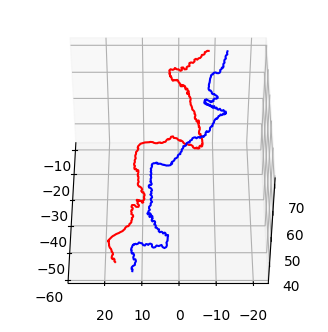

In [167]:
plot_coords_border1 = np.full((3, 3*coords_border1.shape[0] - 3), np.nan)
for i in range(coords_border1.shape[0]-1):
    plot_coords_border1[:, i*3] = coords_border1[i, :]
    plot_coords_border1[:, i*3+1] = coords_border1[i+1, :]
plot_coords_border2 = np.full((3, 3*coords_border2.shape[0] - 3), np.nan)
for i in range(coords_border2.shape[0]-1):
    plot_coords_border2[:, i*3] = coords_border2[i, :]
    plot_coords_border2[:, i*3+1] = coords_border2[i+1, :]
# plot figures
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection='3d')
# ax.scatter(coords_border1[:,0],coords_border1[:,1],coords_border1[:,2], s=0.5, color='k')
# ax.scatter(coords_border2[:,0],coords_border2[:,1],coords_border2[:,2], s=0.5, color='k')
ax.plot(coords_border1[:,0],coords_border1[:,1],coords_border1[:,2], lw=1.5, color='r', zorder=-1)
ax.plot(coords_border2[:,0],coords_border2[:,1],coords_border2[:,2], lw=1.5, color='b', zorder=-1)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
# ax.axis('off')
ax.axis('equal')

# 5. Obtain the corresponding indices for the central prefrontal gyrus, central sulcus and central posterior gyrus after downsampling

In [29]:
# layer 5 roi surface mesh with 1000 elements
L5_surf      = simnibs.read_stl(r'../data_paper/Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
# layer 5 roi surface mesh without discretized
L5_surf_0        = simnibs.read_msh(r'../data_paper/Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
# Load three structures indices
data_index = np.load('../data/pre_central_post_indices_original.npy', allow_pickle=True).item()
precentral_indices  = data_index['precentral_indices']
central_indices     = data_index['central_indices']
postcentral_indices = data_index['postcentral_indices']
# Load four regions indices
indices_four_regions = np.load('../data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI   = indices_four_regions['indices_region_I']
indicesII  = indices_four_regions['indices_region_II']
indicesIII = indices_four_regions['indices_region_III']
indicesIV  = indices_four_regions['indices_region_IV']

In [47]:
save_path = r'../data/pre_central_post_indices_downsampling.npy'
if not os.path.exists(save_path):
    m2m_folder = r'H:\3Headmodel\snowp\m2m_ernie'
    sim_folder = r'H:\3Headmodel\snowp\tacs_2mA'
    meshlab_folder = os.path.join(sim_folder, 'meshlab_file')
    L5_full_surf   = simnibs.read_msh(os.path.join(sim_folder, 'subject_overlays', 'ernie_TDCS_1_scalar_Layer5.msh'))
    
    atlas = simnibs.subject_atlas('a2009s', r'H:\3Headmodel\snowp\m2m_ernie')
    region_name = ['lh.G_precentral', 'lh.S_central', 'lh.G_postcentral']
    three_mesh = []
    three_indeces = []
    for i in range(3):
        roi            = atlas[region_name[i]]
        roi_bool       = roi.astype(bool)
        roi_elm_number = find_elements_composed_by_given_nodes(L5_full_surf, L5_full_surf.nodes.node_number[roi_bool])
        temp_mesh      = L5_full_surf.crop_mesh(elements=roi_elm_number)
        three_mesh.append(temp_mesh)
        _, elm_indices = L5_surf.find_closest_element(temp_mesh.elements_baricenters().value, return_index=True)
        elm_indices   -= 1
        three_indeces.append(np.unique(elm_indices))
    # L5_surf.crop_mesh(elements=three_indeces[2]+1).view().show()

    # save indices
    if not os.path.exists(save_path):
        data = {
            'precentral_indices': three_indeces[0],
            'central_indices': three_indeces[1],
            'postcentral_indices': three_indeces[2]
        }
        np.save(save_path, data)

In [60]:
save_path = r'../data/indices_of_four_regions_in_layer5SOI_downsampling.npy'
if not os.path.exists(save_path):
    list_index   = [indicesI, indicesII, indicesIII, indicesIV]
    four_mesh    = []
    four_indeces = []
    for i in range(4):
        roi_elm_number = np.arange(1, L5_surf_0.elm.nr+1)[list_index[i]]
        temp_mesh = L5_surf_0.crop_mesh(elements=roi_elm_number)
        four_mesh.append(temp_mesh)
        _, elm_indices = L5_surf.find_closest_element(temp_mesh.elements_baricenters().value, return_index=True)
        elm_indices   -= 1
        four_indeces.append(np.unique(elm_indices))
    print(four_indeces[0].shape, four_indeces[1].shape, four_indeces[2].shape, four_indeces[3].shape)

    # save indices
    if not os.path.exists(save_path):
        data = {
            'indices_region_I': four_indeces[0],
            'indices_region_II': four_indeces[1],
            'indices_region_III': four_indeces[2],
            'indices_region_IV': four_indeces[3]
        }
        np.save(save_path, data)